<a href="https://colab.research.google.com/github/cardstud/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/module3-dimensionality-reduction/High_Dimensional_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

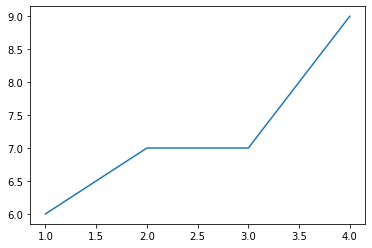

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Passes Vertical Line Test
x1 = [1,2,3,4]
y1 = [6,7,7,9]
plt.plot(x1, y1)


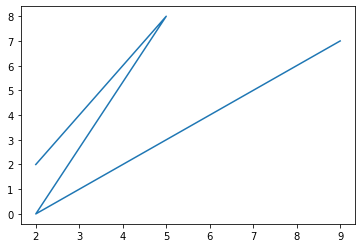

In [0]:
# Does not pass Vertical Line Test
x1 = [2,5,2,9]
y1 = [2,8,0,7]
plt.plot(x1, y1)

## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

Because to be a function, an input can only have one output. In my second graph, 2 has an output of 2 and 0.

# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

In [0]:
# Relation 2 is a function because all the other relations have an input with more than one output

# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

In [0]:
# First one is R3 input with R3 output
# Second one is R4 input with R2 output

## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

In [0]:
# Yes. Example would be f(x,y) = (y-x, x*2+y, x*y)

# Vector Transformations

## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\ \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

**For p:**

\begin{align}
\\
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\ \end{bmatrix}
\\
\end{align}

\\

\begin{align}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = x_1\begin{bmatrix} 1 \\ 0 \end{bmatrix} + x_2\begin{bmatrix} 0 \\ 1 \end{bmatrix}
\\
\end{align}

\\

\begin{align}
p(\begin{bmatrix} 1 \\ 0 \end{bmatrix}) = \begin{bmatrix} 1 \\ -1 \end{bmatrix}
\\
\\
p(\begin{bmatrix} 0 \\ 1 \end{bmatrix}) = \begin{bmatrix} 3 \\ 2 \end{bmatrix}
\end{align}

\\

\begin{align}
T = \begin{bmatrix} 1 & 3 \\ -1 & 2 \end{bmatrix}
\end{align}

**For q**:

\begin{align}
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

\\

\begin{align}
\begin{bmatrix} x_1 \\ x_2 \\ x_3\end{bmatrix} = x_1\begin{bmatrix} 1 \\ 0 \\0 \end{bmatrix} + x_2\begin{bmatrix} 0 \\ 1 \\0 \end{bmatrix} + x_3\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}
\\
\end{align}

\\

\begin{align}
q(\begin{bmatrix} 1 \\ 0 \\0 \end{bmatrix}) = \begin{bmatrix} 4 \\ -1 \\5 \end{bmatrix}
\\
\\
q(\begin{bmatrix} 0 \\ 1 \\0 \end{bmatrix}) = \begin{bmatrix} 1 \\ 2 \\1 \end{bmatrix}
\\
\\
q(\begin{bmatrix} 0 \\ 0 \\1 \end{bmatrix}) = \begin{bmatrix} 2 \\ 3 \\ -2 \end{bmatrix}
\end{align}

\\

\begin{align}
T = \begin{bmatrix} 4 & 1 & 2 \\ -1 & 2 & 3 \\ 5 & 1 & -2 \end{bmatrix}
\end{align}




## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

**For P**:
\begin{align}
p(\begin{bmatrix} 2 \\ 4 \end{bmatrix}) = \begin{bmatrix} 14 \\ 6 \end{bmatrix}
\end{align}

\\


\begin{align}
\begin{bmatrix} 1 & 3 \\ -1 & 2 \end{bmatrix} \begin{bmatrix} 2 \\ 4 \end{bmatrix} = \begin{bmatrix} 14 \\ 6 \end{bmatrix}
\end{align}

**For q**:

\begin{align}
q(\begin{bmatrix} 2 \\ 1 \\3 \end{bmatrix}) = \begin{bmatrix} 15 \\ 9 \\ 5 \end{bmatrix}
\end{align}

\\

\begin{align}
\begin{bmatrix} 4 & 1 & 2 \\ -1 & 2 & 3 \\ 5 & 1 & -2 \end{bmatrix}
\begin{bmatrix} 2 \\ 1 \\3 \end{bmatrix} = \begin{bmatrix} 15 \\ 9 \\ 5 \end{bmatrix}
\end{align}

In [0]:
# To check P using traditional functions:
x1 = 2
x2 = 4
# function x1 + 3x2 and function 2x2-x1
print((x1 + 3*x2))
print((2*x2 - x1))


14
6


In [0]:
# To check q:
x1 = 2
x2 = 1
x3 = 3
# function 4x1 + x2 + 2x3, function 2x2-x2+3x3, function 5x1-2x3+x2
print((4*x1 + x2 + 2*x3))
print((2*x2 - x1 + 3*x3))
print((5*x1 - 2*x3 + x2))


15
9
5


# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

Eigenvectors are vectors that are not changed when scaled, they can be stretched or squished but do not change direction during the transformation.

Eigenvalues are the scalars that represent how the eigenvector was scaled.

# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

1.   The higher the dimension, the more difficult it is to explore the data and create visualizations
2.   Adding more features causes an increase in redundancy leading to diminshing returns
3.   Increased computational workload that is not necessary
4.   Increase sparcity of data, distance between points increases
5.   Low number of observations compared to dimensions leads to overfitting your data 




## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

A good rule of thumb is to have about 5 times more observations than parameters

# Principal Component Analysis

## 7.1 Code for loading and cleaning the 2013 national dataset from the [Housing Affordability Data System (HADS)](https://www.huduser.gov/portal/datasets/hads/hads.html) --housing data, can be found below. 

## Perform PCA on the processed dataset `national_processed` (Make sure you standardize your data!) and then make a scatterplot of PC1 against PC2. Some of our discussion and work around PCA with this dataset will continue during tomorrow's lecture and assignment.

Not only does this dataset have decent amount columns to begin with (99), but in preparing the data for PCA we have also [one-hot-encoded](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f#targetText=One%20hot%20encoding%20is%20a,the%20entry%20in%20the%20dataset.) all of the categorical variables. This has the effect of creating a new column for each individual category of each categorical variable. After processing this dataset has 64738 columns. --Das a lot of columns.

Don't worry too much about the mechanics of one-hot encoding right now, you will learn and experiment with a whole bunch of categorical encoding approaches in unit 2. 

The code below will read in the dataset and perform the one-hot encoding of the categorical variables. Start adding your PCA code at the bottom of the provided code.

In [0]:
import os.path
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import pandas as pd

# Read National Data 
national_url = 'https://www.huduser.gov/portal/datasets/hads/hads2013n_ASCII.zip'
national_file = 'thads2013n.txt'

if os.path.exists(national_file):
    national = pd.read_csv(national_file)
else: 
    z_national = urlopen(national_url)
    zip_national = ZipFile(BytesIO(z_national.read())).extract(national_file)
    national = pd.read_csv(zip_national)

In [0]:
# Look at first 5 rows
print(national.shape)
national.head()

(64535, 99)


,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,BEDRMS,BUILT,STATUS,TYPE,VALUE,VACANCY,TENURE,NUNITS,ROOMS,WEIGHT,PER,ZINC2,ZADEQ,ZSMHC,STRUCTURETYPE,OWNRENT,UTILITY,OTHERCOST,COST06,COST12,COST08,COSTMED,TOTSAL,ASSISTED,GLMED,GL30,GL50,GL80,APLMED,ABL30,...,COST08RELPOVCAT,COST08RELFMRPCT,COST08RELFMRCAT,COST12RELAMIPCT,COST12RELAMICAT,COST12RELPOVPCT,COST12RELPOVCAT,COST12RELFMRPCT,COST12RELFMRCAT,COSTMedRELAMIPCT,COSTMedRELAMICAT,COSTMedRELPOVPCT,COSTMedRELPOVCAT,COSTMedRELFMRPCT,COSTMedRELFMRCAT,FMTZADEQ,FMTMETRO3,FMTBUILT,FMTSTRUCTURETYPE,FMTBEDRMS,FMTOWNRENT,FMTCOST06RELPOVCAT,FMTCOST08RELPOVCAT,FMTCOST12RELPOVCAT,FMTCOSTMEDRELPOVCAT,FMTINCRELPOVCAT,FMTCOST06RELFMRCAT,FMTCOST08RELFMRCAT,FMTCOST12RELFMRCAT,FMTCOSTMEDRELFMRCAT,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS
0,'100003130103',82,'3','1',73738,956,15738,26213,40322,11067,2,2006,'1',1,40000,-6,'1',1,6,3117.394239,1,18021,'1',533,1,'1',169.000000,213.750000,648.588189,803.050535,696.905247,615.156712,0,-9,73738,15738,26213,40322,51616.6,20234.571429,...,4,72.898038,2,48.402635,2,290.250487,4,84.001102,2,37.077624,2,222.339102,4,64.346936,2,'1 Adequate','-5','2000-2009','1 Single Family','2 2BR','1 Owner','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','3 150-200% Poverty','2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','1 LTE 50% FMR','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','.','2 30% to 50%','-5','-5'
1,'100006110249',50,'5','3',55846,1100,17165,28604,45744,24218,4,1980,'1',1,130000,-6,'1',1,6,2150.725544,4,122961,'1',487,1,'1',245.333333,58.333333,1167.640781,1669.643405,1324.671218,1058.988479,123000,-9,55846,17165,28604,45744,55846.0,19911.400000,...,4,120.424656,3,103.094063,6,275.768999,4,151.785764,3,65.388468,4,174.909320,3,96.271680,2,'1 Adequate','-5','1980-1989','1 Single Family','4 4BR+','1 Owner','3 150-200% Poverty','4 200%+ Poverty','4 200%+ Poverty','3 150-200% Poverty','4 200%+ Poverty','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','3 GT FMR','4 60 - 80% AMI','4 60 - 80% AMI','6 100 - 120% AMI','4 60 - 80% AMI','7 120% AMI +','.','1 Less than 30%','-5','-5'
2,'100006370140',53,'5','3',55846,1100,13750,22897,36614,15470,4,1985,'1',1,150000,-6,'1',1,7,2213.789404,2,27974,'1',1405,1,'1',159.000000,37.500000,1193.393209,1772.627006,1374.582175,1068.025168,28000,-9,55846,13750,22897,36614,44676.8,19937.500000,...,4,124.962016,3,109.452905,6,458.339239,4,161.147910,3,65.946449,4,276.153890,4,97.093197,2,'1 Adequate','-5','1980-1989','1 Single Family','4 4BR+','1 Owner','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','3 150-200% Poverty','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','4 60 - 80% AMI','5 80 - 100% AMI','6 100 - 120% AMI','4 60 - 80% AMI','4 60 - 80% AMI','.','3 50% or More','-5','-5'
3,'100006520140',67,'5','3',55846,949,13750,22897,36614,13964,3,1985,'1',1,200000,-6,'1',1,6,2364.585097,2,32220,'1',279,1,'1',179.000000,70.666667,1578.857612,2351.169341,1820.442900,1411.700224,0,-9,55846,13750,22897,36614,44676.8,17875.000000,...,4,191.827492,3,161.926709,7,673.494512,4,247.752301,3,97.224801,5,404.382763,4,148.756610,3,'1 Adequate','-5','1980-1989','1 Single Family','3 3BR','1 Owner','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','3 GT FMR','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','6 100 - 120% AMI','7 120% AMI +','7 120% AMI +','5 80 - 100% AMI','4 60 - 80% AMI','.','1 Less than 30%','-5','-5'
4,'100007130148',26,'1','3',60991,737,14801,24628,39421,15492,2,1980,'1',1,-6,-6,'2',100,4,2314.524902,2,96874,'1',759,5,'2',146.000000,12.500000,759.000000,759.000000,759.000000,759.000000,96900,0,60991,14801,24628,39421,48792.8,16651.125000,...,3,102.985075,3,55.308707,3,195.972115,3,102.985075,3,55.308707,3,195.972115,3,102.98

In [0]:
# Look at datatypes
# a lot of object datatypes even though they look to be strings of numbers.
national.dtypes

CONTROL            object
AGE1                int64
METRO3             object
REGION             object
LMED                int64
                    ...  
FMTINCRELAMICAT    object
FMTASSISTED        object
FMTBURDEN          object
FMTREGION          object
FMTSTATUS          object
Length: 99, dtype: object

In [0]:
# check for null values
national.isnull().sum().any()

False

In [0]:
# check for number of categorical vs numeric columns
cat_cols = national.columns[national.dtypes=='object']
num_cols = national.columns[national.dtypes!='object']

print(f'{len(cat_cols)} categorical columns')
print(f'{len(num_cols)} numerical columns')

32 categorical columns
67 numerical columns


In [0]:
# cast categorical columns to "category" data type
national[cat_cols] = national[cat_cols].astype('category')
national.dtypes

CONTROL            category
AGE1                  int64
METRO3             category
REGION             category
LMED                  int64
                     ...   
FMTINCRELAMICAT    category
FMTASSISTED        category
FMTBURDEN          category
FMTREGION          category
FMTSTATUS          category
Length: 99, dtype: object

In [0]:
national.head()

,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,BEDRMS,BUILT,STATUS,TYPE,VALUE,VACANCY,TENURE,NUNITS,ROOMS,WEIGHT,PER,ZINC2,ZADEQ,ZSMHC,STRUCTURETYPE,OWNRENT,UTILITY,OTHERCOST,COST06,COST12,COST08,COSTMED,TOTSAL,ASSISTED,GLMED,GL30,GL50,GL80,APLMED,ABL30,...,COST08RELPOVCAT,COST08RELFMRPCT,COST08RELFMRCAT,COST12RELAMIPCT,COST12RELAMICAT,COST12RELPOVPCT,COST12RELPOVCAT,COST12RELFMRPCT,COST12RELFMRCAT,COSTMedRELAMIPCT,COSTMedRELAMICAT,COSTMedRELPOVPCT,COSTMedRELPOVCAT,COSTMedRELFMRPCT,COSTMedRELFMRCAT,FMTZADEQ,FMTMETRO3,FMTBUILT,FMTSTRUCTURETYPE,FMTBEDRMS,FMTOWNRENT,FMTCOST06RELPOVCAT,FMTCOST08RELPOVCAT,FMTCOST12RELPOVCAT,FMTCOSTMEDRELPOVCAT,FMTINCRELPOVCAT,FMTCOST06RELFMRCAT,FMTCOST08RELFMRCAT,FMTCOST12RELFMRCAT,FMTCOSTMEDRELFMRCAT,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS
0,'100003130103',82,'3','1',73738,956,15738,26213,40322,11067,2,2006,'1',1,40000,-6,'1',1,6,3117.394239,1,18021,'1',533,1,'1',169.000000,213.750000,648.588189,803.050535,696.905247,615.156712,0,-9,73738,15738,26213,40322,51616.6,20234.571429,...,4,72.898038,2,48.402635,2,290.250487,4,84.001102,2,37.077624,2,222.339102,4,64.346936,2,'1 Adequate','-5','2000-2009','1 Single Family','2 2BR','1 Owner','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','3 150-200% Poverty','2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','1 LTE 50% FMR','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','.','2 30% to 50%','-5','-5'
1,'100006110249',50,'5','3',55846,1100,17165,28604,45744,24218,4,1980,'1',1,130000,-6,'1',1,6,2150.725544,4,122961,'1',487,1,'1',245.333333,58.333333,1167.640781,1669.643405,1324.671218,1058.988479,123000,-9,55846,17165,28604,45744,55846.0,19911.400000,...,4,120.424656,3,103.094063,6,275.768999,4,151.785764,3,65.388468,4,174.909320,3,96.271680,2,'1 Adequate','-5','1980-1989','1 Single Family','4 4BR+','1 Owner','3 150-200% Poverty','4 200%+ Poverty','4 200%+ Poverty','3 150-200% Poverty','4 200%+ Poverty','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','3 GT FMR','4 60 - 80% AMI','4 60 - 80% AMI','6 100 - 120% AMI','4 60 - 80% AMI','7 120% AMI +','.','1 Less than 30%','-5','-5'
2,'100006370140',53,'5','3',55846,1100,13750,22897,36614,15470,4,1985,'1',1,150000,-6,'1',1,7,2213.789404,2,27974,'1',1405,1,'1',159.000000,37.500000,1193.393209,1772.627006,1374.582175,1068.025168,28000,-9,55846,13750,22897,36614,44676.8,19937.500000,...,4,124.962016,3,109.452905,6,458.339239,4,161.147910,3,65.946449,4,276.153890,4,97.093197,2,'1 Adequate','-5','1980-1989','1 Single Family','4 4BR+','1 Owner','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','3 150-200% Poverty','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','2 50.1 - 100% FMR','4 60 - 80% AMI','5 80 - 100% AMI','6 100 - 120% AMI','4 60 - 80% AMI','4 60 - 80% AMI','.','3 50% or More','-5','-5'
3,'100006520140',67,'5','3',55846,949,13750,22897,36614,13964,3,1985,'1',1,200000,-6,'1',1,6,2364.585097,2,32220,'1',279,1,'1',179.000000,70.666667,1578.857612,2351.169341,1820.442900,1411.700224,0,-9,55846,13750,22897,36614,44676.8,17875.000000,...,4,191.827492,3,161.926709,7,673.494512,4,247.752301,3,97.224801,5,404.382763,4,148.756610,3,'1 Adequate','-5','1980-1989','1 Single Family','3 3BR','1 Owner','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','4 200%+ Poverty','3 GT FMR','3 GT FMR','3 GT FMR','3 GT FMR','2 50.1 - 100% FMR','6 100 - 120% AMI','7 120% AMI +','7 120% AMI +','5 80 - 100% AMI','4 60 - 80% AMI','.','1 Less than 30%','-5','-5'
4,'100007130148',26,'1','3',60991,737,14801,24628,39421,15492,2,1980,'1',1,-6,-6,'2',100,4,2314.524902,2,96874,'1',759,5,'2',146.000000,12.500000,759.000000,759.000000,759.000000,759.000000,96900,0,60991,14801,24628,39421,48792.8,16651.125000,...,3,102.985075,3,55.308707,3,195.972115,3,102.985075,3,55.308707,3,195.972115,3,102.98

In [0]:
# accessor now that we stored the cat_cols as category type
national['FMTOWNRENT']

0         '1 Owner'
1         '1 Owner'
2         '1 Owner'
3         '1 Owner'
4        '2 Renter'
            ...    
64530    '2 Renter'
64531    '2 Renter'
64532    '2 Renter'
64533    '2 Renter'
64534    '2 Renter'
Name: FMTOWNRENT, Length: 64535, dtype: category
Categories (2, object): ['1 Owner', '2 Renter']

In [0]:
national['FMTOWNRENT'].cat.codes.head()

0    0
1    0
2    0
3    0
4    1
dtype: int8

In [0]:
national['FMTOWNRENT'].cat.codes

0        0
1        0
2        0
3        0
4        1
        ..
64530    1
64531    1
64532    1
64533    1
64534    1
Length: 64535, dtype: int8

##### Function for reducing memory usage of a pandas dataframe


https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65


def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :" ,start_mem_usg," MB")
    NAlist = []  # keeps track of columns that have missing values filled in
    for col in props.columns:
        if props[col].dtype != object:   # Exclude strings
        
            # Print current column type
            print("******************************")
            print("Column: ", col)
            print("dtype before: ", props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(mn-1, inplace=True)
                
            
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
                

In [0]:
for col in cat_cols:
  national[col] = national[col].cat.codes
  
print(national.shape)
national.head()

(64535, 99)


,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,BEDRMS,BUILT,STATUS,TYPE,VALUE,VACANCY,TENURE,NUNITS,ROOMS,WEIGHT,PER,ZINC2,ZADEQ,ZSMHC,STRUCTURETYPE,OWNRENT,UTILITY,OTHERCOST,COST06,COST12,COST08,COSTMED,TOTSAL,ASSISTED,GLMED,GL30,GL50,GL80,APLMED,ABL30,...,COST08RELPOVCAT,COST08RELFMRPCT,COST08RELFMRCAT,COST12RELAMIPCT,COST12RELAMICAT,COST12RELPOVPCT,COST12RELPOVCAT,COST12RELFMRPCT,COST12RELFMRCAT,COSTMedRELAMIPCT,COSTMedRELAMICAT,COSTMedRELPOVPCT,COSTMedRELPOVCAT,COSTMedRELFMRPCT,COSTMedRELFMRCAT,FMTZADEQ,FMTMETRO3,FMTBUILT,FMTSTRUCTURETYPE,FMTBEDRMS,FMTOWNRENT,FMTCOST06RELPOVCAT,FMTCOST08RELPOVCAT,FMTCOST12RELPOVCAT,FMTCOSTMEDRELPOVCAT,FMTINCRELPOVCAT,FMTCOST06RELFMRCAT,FMTCOST08RELFMRCAT,FMTCOST12RELFMRCAT,FMTCOSTMEDRELFMRCAT,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS
0,0,82,2,0,73738,956,15738,26213,40322,11067,2,2006,0,1,40000,-6,1,1,6,3117.394239,1,18021,1,533,1,0,169.000000,213.750000,648.588189,803.050535,696.905247,615.156712,0,-9,73738,15738,26213,40322,51616.6,20234.571429,...,4,72.898038,2,48.402635,2,290.250487,4,84.001102,2,37.077624,2,222.339102,4,64.346936,2,1,0,5,1,2,0,4,4,4,4,3,1,1,1,1,1,1,1,1,1,2,0,2,0,0
1,1,50,4,2,55846,1100,17165,28604,45744,24218,4,1980,0,1,130000,-6,1,1,6,2150.725544,4,122961,1,487,1,0,245.333333,58.333333,1167.640781,1669.643405,1324.671218,1058.988479,123000,-9,55846,17165,28604,45744,55846.0,19911.400000,...,4,120.424656,3,103.094063,6,275.768999,4,151.785764,3,65.388468,4,174.909320,3,96.271680,2,1,0,3,1,4,0,3,4,4,3,4,2,2,2,1,3,3,3,5,3,7,0,1,0,0
2,2,53,4,2,55846,1100,13750,22897,36614,15470,4,1985,0,1,150000,-6,1,1,7,2213.789404,2,27974,1,1405,1,0,159.000000,37.500000,1193.393209,1772.627006,1374.582175,1068.025168,28000,-9,55846,13750,22897,36614,44676.8,19937.500000,...,4,124.962016,3,109.452905,6,458.339239,4,161.147910,3,65.946449,4,276.153890,4,97.093197,2,1,0,3,1,4,0,4,4,4,4,3,2,2,2,1,2,3,4,5,3,4,0,3,0,0
3,3,67,4,2,55846,949,13750,22897,36614,13964,3,1985,0,1,200000,-6,1,1,6,2364.585097,2,32220,1,279,1,0,179.000000,70.666667,1578.857612,2351.169341,1820.442900,1411.700224,0,-9,55846,13750,22897,36614,44676.8,17875.000000,...,4,191.827492,3,161.926709,7,673.494512,4,247.752301,3,97.224801,5,404.382763,4,148.756610,3,1,0,3,1,3,0,4,4,4,4,4,2,2,2,2,2,5,6,6,4,4,0,1,0,0
4,4,26,0,2,60991,737,14801,24628,39421,15492,2,1980,0,1,-6,-6,2,100,4,2314.524902,2,96874,1,759,5,1,146.000000,12.500000,759.000000,759.000000,759.000000,759.000000,96900,0,60991,14801,24628,39421,48792.8,16651.125000,...,3,102.985075,3,55.308707,3,195.972115,3,102.985075,3,55.308707,3,195.972115,3,102.985075,3,1,1,3,5,2,1,3,3,3,3,4,2,2,2,2,3,2,2,2,2,7,1,1,0,0


In [0]:
# Make copy of our dataframe, we will standardize the copy so as to not overwrite
#    our original data
national_processed = national.copy()

# Get One-Hot-Encoding of categorical variables
#national_processed = pd.get_dummies(national_processed)
print(national_processed.shape)
national_processed.head()

(64535, 99)


,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,BEDRMS,BUILT,STATUS,TYPE,VALUE,VACANCY,TENURE,NUNITS,ROOMS,WEIGHT,PER,ZINC2,ZADEQ,ZSMHC,STRUCTURETYPE,OWNRENT,UTILITY,OTHERCOST,COST06,COST12,COST08,COSTMED,TOTSAL,ASSISTED,GLMED,GL30,GL50,GL80,APLMED,ABL30,...,COST08RELPOVCAT,COST08RELFMRPCT,COST08RELFMRCAT,COST12RELAMIPCT,COST12RELAMICAT,COST12RELPOVPCT,COST12RELPOVCAT,COST12RELFMRPCT,COST12RELFMRCAT,COSTMedRELAMIPCT,COSTMedRELAMICAT,COSTMedRELPOVPCT,COSTMedRELPOVCAT,COSTMedRELFMRPCT,COSTMedRELFMRCAT,FMTZADEQ,FMTMETRO3,FMTBUILT,FMTSTRUCTURETYPE,FMTBEDRMS,FMTOWNRENT,FMTCOST06RELPOVCAT,FMTCOST08RELPOVCAT,FMTCOST12RELPOVCAT,FMTCOSTMEDRELPOVCAT,FMTINCRELPOVCAT,FMTCOST06RELFMRCAT,FMTCOST08RELFMRCAT,FMTCOST12RELFMRCAT,FMTCOSTMEDRELFMRCAT,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS
0,0,82,2,0,73738,956,15738,26213,40322,11067,2,2006,0,1,40000,-6,1,1,6,3117.394239,1,18021,1,533,1,0,169.000000,213.750000,648.588189,803.050535,696.905247,615.156712,0,-9,73738,15738,26213,40322,51616.6,20234.571429,...,4,72.898038,2,48.402635,2,290.250487,4,84.001102,2,37.077624,2,222.339102,4,64.346936,2,1,0,5,1,2,0,4,4,4,4,3,1,1,1,1,1,1,1,1,1,2,0,2,0,0
1,1,50,4,2,55846,1100,17165,28604,45744,24218,4,1980,0,1,130000,-6,1,1,6,2150.725544,4,122961,1,487,1,0,245.333333,58.333333,1167.640781,1669.643405,1324.671218,1058.988479,123000,-9,55846,17165,28604,45744,55846.0,19911.400000,...,4,120.424656,3,103.094063,6,275.768999,4,151.785764,3,65.388468,4,174.909320,3,96.271680,2,1,0,3,1,4,0,3,4,4,3,4,2,2,2,1,3,3,3,5,3,7,0,1,0,0
2,2,53,4,2,55846,1100,13750,22897,36614,15470,4,1985,0,1,150000,-6,1,1,7,2213.789404,2,27974,1,1405,1,0,159.000000,37.500000,1193.393209,1772.627006,1374.582175,1068.025168,28000,-9,55846,13750,22897,36614,44676.8,19937.500000,...,4,124.962016,3,109.452905,6,458.339239,4,161.147910,3,65.946449,4,276.153890,4,97.093197,2,1,0,3,1,4,0,4,4,4,4,3,2,2,2,1,2,3,4,5,3,4,0,3,0,0
3,3,67,4,2,55846,949,13750,22897,36614,13964,3,1985,0,1,200000,-6,1,1,6,2364.585097,2,32220,1,279,1,0,179.000000,70.666667,1578.857612,2351.169341,1820.442900,1411.700224,0,-9,55846,13750,22897,36614,44676.8,17875.000000,...,4,191.827492,3,161.926709,7,673.494512,4,247.752301,3,97.224801,5,404.382763,4,148.756610,3,1,0,3,1,3,0,4,4,4,4,4,2,2,2,2,2,5,6,6,4,4,0,1,0,0
4,4,26,0,2,60991,737,14801,24628,39421,15492,2,1980,0,1,-6,-6,2,100,4,2314.524902,2,96874,1,759,5,1,146.000000,12.500000,759.000000,759.000000,759.000000,759.000000,96900,0,60991,14801,24628,39421,48792.8,16651.125000,...,3,102.985075,3,55.308707,3,195.972115,3,102.985075,3,55.308707,3,195.972115,3,102.985075,3,1,1,3,5,2,1,3,3,3,3,4,2,2,2,2,3,2,2,2,2,7,1,1,0,0


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
national_processed = scaler.fit_transform(national_processed)
national_processed

array([[-1.73202397,  1.48807451,  0.60878419, ...,  0.54947295,
        -0.46210707,  0.        ],
       [-1.73197029,  0.08881241,  2.18426992, ..., -0.54470863,
        -0.46210707,  0.        ],
       [-1.73191661,  0.21999323,  2.18426992, ...,  1.64365453,
        -0.46210707,  0.        ],
       ...,
       [ 1.73191661, -1.09181499, -0.17895868, ...,  1.64365453,
         2.16400067,  0.        ],
       [ 1.73197029,  0.39490099, -0.96670154, ..., -0.54470863,
         2.16400067,  0.        ],
       [ 1.73202397,  0.78844346,  1.39652706, ..., -0.54470863,
        -0.46210707,  0.        ]])

In [0]:
from sklearn.decomposition import PCA

# Apply PCA to the data
pca = PCA(n_components=20)
pca_features = pca.fit_transform(national_processed)

In [0]:
# Define scree plot function
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.scatter(ind, vals)
    ax.plot(ind, vals, color='r')
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

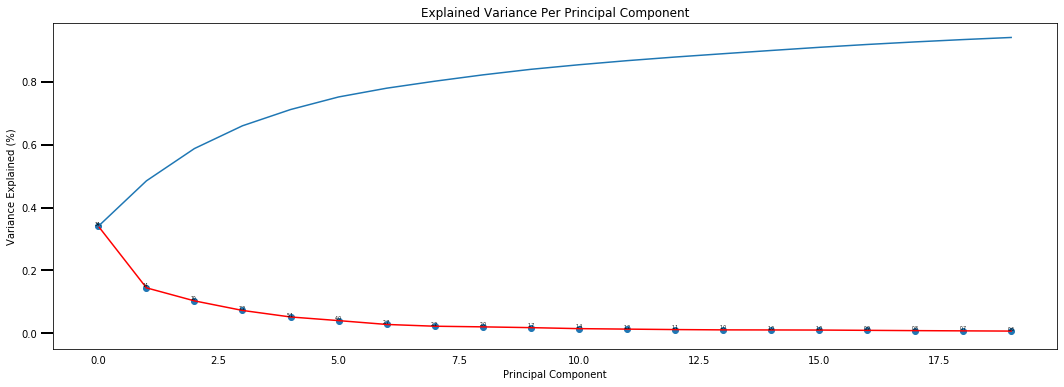

In [0]:
scree_plot(pca)

# Stretch Goals

## 1) Perform further data exploration on the HADS national dataset (the version before we one-hot encoded it) Make scatterplots and see if you can see any resemblance between the original scatterplots and the plot of the principal components that you made in 7.1. 

(You may or may not not see very much resemblance depending on the variables you choose, and that's ok!)

## 2) Study "Scree Plots" and then try and make one for your PCA dataset. How many principal conponents do you need to retain in order for your PCs to contain 90% of the explained variance? 

We will present this topic formally at the beginning of tomorrow's lecture, so if you figure this stretch goal out, you're ahead of the game. 

## 3) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

Prioritize self-study over this stretch goal if you are not semi-comfortable with the topics of PCA, Eigenvalues, and Eigenvectors.

![Eigenfaces](https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg)

You don't necessarily have to use this resource, but this will get you started: 
[Eigenface Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)